# 1. Chuẩn bị dữ liệu.

In [0]:
from google.colab import drive
import os

drive.mount("/content/gdrive")
path = "/content/gdrive/My Drive/Colab Notebooks/Facenet"
os.chdir(path)
!ls

In [0]:
!wget https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/YALE.tar.gz

--2020-03-19 02:17:35--  https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/YALE.tar.gz
Resolving vismod.media.mit.edu (vismod.media.mit.edu)... 18.27.72.36
Connecting to vismod.media.mit.edu (vismod.media.mit.edu)|18.27.72.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30032961 (29M) [application/x-gzip]
Saving to: ‘YALE.tar.gz’

YALE.tar.gz         100%[===================>]  28.64M  18.7MB/s    in 1.5s    

2020-03-19 02:17:36 (18.7 MB/s) - ‘YALE.tar.gz’ saved [30032961/30032961]



In [0]:
# !tar xvfz YALE.tar.gz

In [0]:
from PIL import Image
# from imutils import paths
import glob2
import numpy as np

image_files = glob2.glob("YALE/centered/*")
names = []
states = []
images = []
for link in image_files:
  name = link.split("/")[-1].split(".")[0]
  state = link.split("/")[-1].split(".")[1]
  image = np.array(Image.open(link))
  names.append(name)
  states.append(state)
  images.append(image)

In [7]:
print(len(images))
print(np.unique(names, return_counts = True))

165
(array(['subject01', 'subject02', 'subject03', 'subject04', 'subject05',
       'subject06', 'subject07', 'subject08', 'subject09', 'subject10',
       'subject11', 'subject12', 'subject13', 'subject14', 'subject15'],
      dtype='<U9'), array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]))


In [0]:
%tensorflow_version 2.x

In [9]:
import cv2

faceResizes = []
for face in images:
  face_rz = cv2.resize(face, (224, 224))
  faceResizes.append(face_rz)

X = np.stack(faceResizes)
X.shape

(165, 224, 224)

Visualize các ảnh trên cùng 1 nhãn.

In [47]:
# np.where(names == 'subject01')
np.where(names=='subject02')

# names

(array([], dtype=int64),)

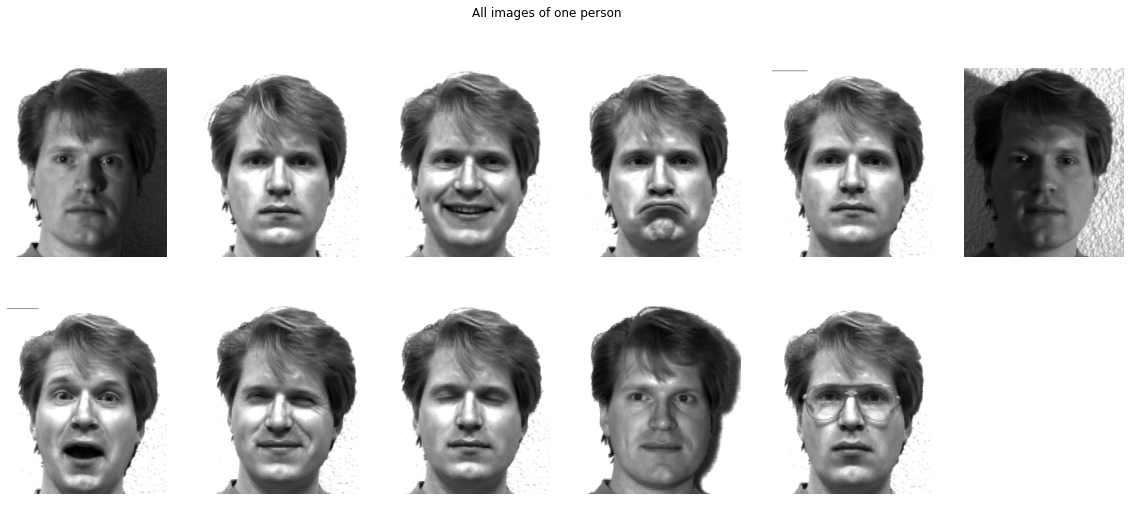

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob



def _show_images(person):
  # Khởi tạo subplot với 2 dòng 5 cột.
  fg, ax = plt.subplots(2, 6, figsize=(20, 8))
  fg.suptitle('All images of one person')
  ids = np.flatnonzero(np.array(names) == person)
  total = 0
  for i in np.arange(2):
    for j in np.arange(6):
      try:
        image = cv2.cvtColor(images[ids[total]], cv2.COLOR_BGR2RGB)
        total+=1
        ax[i, j].imshow(image)
        ax[i, j].axis('off')
      except:
        ax[i, j].axis('off')
        next

_show_images('subject01')

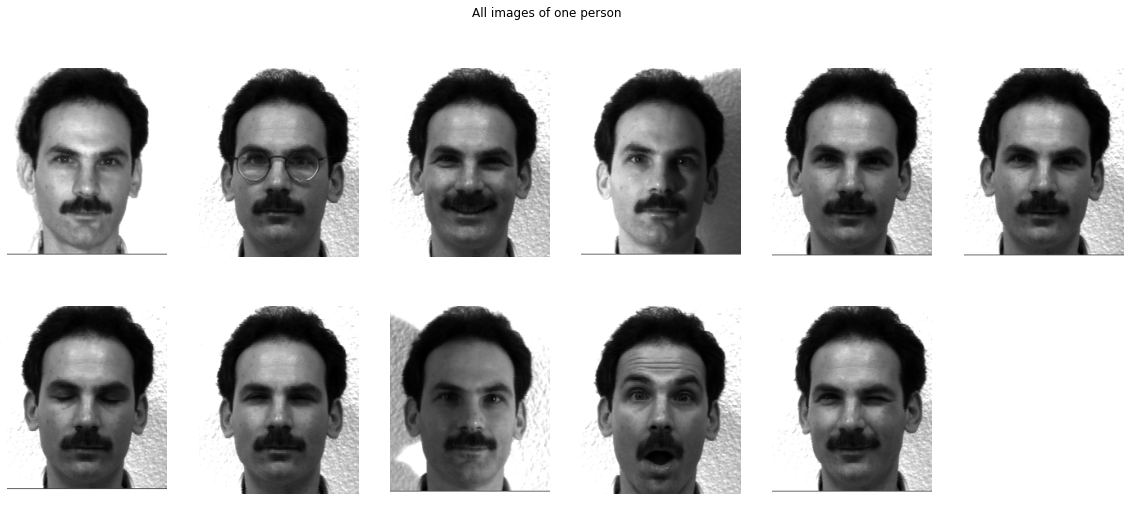

In [57]:
_show_images('subject02')

Nhận xét:

* Mỗi một object đều có đầy đủ 11 trạng thái: ‘centerlight’, ‘glasses’, ‘happy’, ‘leftlight’, ‘noglasses’, ‘normal’, ‘rightlight’,’sad’, ‘sleepy’, ‘surprised’, và ‘wink’.
* Các bức ảnh đồng nhất về điều kiện chụp.
* Cường độ màu sắc giữa các ảnh là tương tự nhau.
* Vị trí khuôn mặt đều chính diện.

# 2. Huấn luyện model

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, names, np.array((X)), stratify = names, test_size = 1/11)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(np.unique(y_test, return_counts=True))

(150, 224, 224)
(15, 224, 224)
(array(['subject01', 'subject02', 'subject03', 'subject04', 'subject05',
       'subject06', 'subject07', 'subject08', 'subject09', 'subject10',
       'subject11', 'subject12', 'subject13', 'subject14', 'subject15'],
      dtype='<U9'), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))


In [0]:
import pickle

def _save_pickle(obj, link):
  with open(link, "wb") as f:
    pickle.dump(obj, f)

def _load_pickle(link):
  with open(link, "rb") as f:
    obj = pickle.load(f)
  return obj

_save_pickle(X, "YALE/X.pkl")
_save_pickle(names, "YALE/y.pkl")

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

def _base_network():
  model = VGG16(include_top = True, weights = None, input_tensor=Input(shape=(224, 224, 1)))
  dense = Dense(128)(model.layers[-4].output)
  norm2 = Lambda(lambda x: tf.math.l2_normalize(x, axis = 1))(dense)
  model = Model(inputs = [model.input], outputs = [norm2])
  return model

model = _base_network()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

In [0]:
gen_train = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_train, axis=-1), y_train)).repeat().shuffle(1024).batch(32)
gen_train

<BatchDataset shapes: ((None, 224, 224, 1), (None,)), types: (tf.uint8, tf.string)>

In [0]:
history = model.fit(
    gen_train,
    steps_per_epoch = 50,
    epochs=10)

Train for 50 steps
Epoch 1/10
50/50 [==============================] - 2806s 56s/step - loss: 0.9435
Epoch 2/10
50/50 [==============================] - 2801s 56s/step - loss: 0.5723
Epoch 3/10
50/50 [==============================] - 2802s 56s/step - loss: 0.3289
Epoch 4/10
50/50 [==============================] - 2806s 56s/step - loss: 0.1622
Epoch 5/10
50/50 [==============================] - 2803s 56s/step - loss: 0.0577
Epoch 6/10
50/50 [==============================] - 2805s 56s/step - loss: 0.0233
Epoch 7/10
50/50 [==============================] - 2807s 56s/step - loss: 0.0080
Epoch 8/10
50/50 [==============================] - 2805s 56s/step - loss: 5.5516e-04
Epoch 9/10
50/50 [==============================] - 2810s 56s/step - loss: 6.5311e-05
Epoch 10/10
 4/50 [=>............................] - ETA: 43:03 - loss: 0.0000e+00

KeyboardInterrupt: ignored

Thấy độ loss function đã hội tụ về gần 0 nên mình tắt đi cho đỡ tốn thời gian. Nhờ save model lại. Bạn có thể tạo một checkpoint save_best_only cho model.

In [0]:
model.save('face_yale.h5')

# 1. Dự báo cho model

In [0]:
model.load_weights('face_yale.h5')

Dự báo các véc tơ embedding.

In [0]:
X_train_vecs = model.predict(np.expand_dims(X_train, axis = -1))
X_test_vecs = model.predict(np.expand_dims(X_test, axis = -1))

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

def _most_similarity(embed_vecs, vec, labels):
  sim = cosine_similarity(embed_vecs, vec)
  sim = np.squeeze(sim, axis = 1)
  argmax = np.argsort(sim)[::-1][:1]
  label = [labels[idx] for idx in argmax][0]
  return label

# Lấy ngẫu nhiên một bức ảnh trong test
vec = X_test_vecs[1].reshape(1, -1)
# Tìm kiếm ảnh gần nhất
_most_similarity(X_train_vecs, vec, y_train)

'subject11'

Kiểm tra độ chính xác trên tập test

In [23]:
from sklearn.metrics import accuracy_score
y_preds = []
for vec in X_test_vecs:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train_vecs, vec, y_train)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_test))

1.0


Kiểm tra độ chính xác trên tập train

In [24]:
from sklearn.metrics import accuracy_score
y_preds = []
for vec in X_train_vecs:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train_vecs, vec, y_train)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_train))

1.0


Như vậy với một bộ ảnh mà cùng 1 điều kiện môi trường, ánh sáng và đầy đủ các trạng thái của khuôn mặt thì accuracy của model rất cao. Dường như đạt 100%.